In [1]:
from train_shap import get_model_data_for_shap, ModelReversingY, get_data_for_Shap
import shap
import joblib
# beA3o82D_1112_1_all
fmodel, params, pp, fp= get_model_data_for_shap('trainshap_timeseries.yaml', 'beA3o82D', 1112)
joblib.dump(fmodel, 'fmodel.pkl')

2024-10-12 22:42:34.113 | INFO     | preprocessor:_dropna:160 - Dropping NaN values
2024-10-12 22:42:34.325 | INFO     | preprocessor:_dropna:184 - Columns with NaN values: Index(['Hematocrit_Avg_preclinical', 'Hematocrit_Avg_acute',
       'Hematocrit_Avg_chronic', 'LymphocytesPercentage_Avg_preclinical',
       'LymphocytesPercentage_Avg_acute', 'LymphocytesPercentage_Avg_chronic',
       'NeutrophilsPercentage_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MonocytesPercentage_Avg_preclinical',
       ...
       'Crab_Avg_chronic', 'MixedGrasses_Avg_preclinical',
       'MixedGrasses_Avg_acute', 'MixedGrasses_Avg_chronic',
       'Mugwort_Avg_preclinical', 'Mugwort_Avg_acute', 'Mugwort_Avg_chronic',
       'Salmon_Avg_preclinical', 'Salmon_Avg_acute', 'Salmon_Avg_chronic'],
      dtype='object', length=233)
2024-10-12 22:42:34.330 | INFO     | preprocessor:_imputation:196 - Imputing missing values
2024-10-12 22:42:35.324 | INF

[0]	train-rmsle:1.31736	train-roc_auc:0.65545	validation-rmsle:1.28875	validation-roc_auc:0.64356
[1]	train-rmsle:1.27588	train-roc_auc:0.71666	validation-rmsle:1.24833	validation-roc_auc:0.68910
[2]	train-rmsle:1.23590	train-roc_auc:0.71234	validation-rmsle:1.20931	validation-roc_auc:0.68676
[3]	train-rmsle:1.19752	train-roc_auc:0.71666	validation-rmsle:1.17209	validation-roc_auc:0.68910
[4]	train-rmsle:1.16074	train-roc_auc:0.71666	validation-rmsle:1.13651	validation-roc_auc:0.68910
[5]	train-rmsle:1.12563	train-roc_auc:0.71664	validation-rmsle:1.10235	validation-roc_auc:0.68917
[6]	train-rmsle:1.09212	train-roc_auc:0.71541	validation-rmsle:1.06995	validation-roc_auc:0.68907
[7]	train-rmsle:1.06028	train-roc_auc:0.71250	validation-rmsle:1.03925	validation-roc_auc:0.68716
[8]	train-rmsle:1.03018	train-roc_auc:0.71541	validation-rmsle:1.01051	validation-roc_auc:0.68907
[9]	train-rmsle:1.00176	train-roc_auc:0.71664	validation-rmsle:0.98349	validation-roc_auc:0.68917
[10]	train-rmsle:0.9

['fmodel.pkl']

In [20]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from loguru import logger
from preprocessor import get_asso_feat
import seaborn as sns


def plot_kde_distribution(X, y , exposure):
    # 如果用户选择保存图像，则检查是否已经存在
    col2 = 'VisitDuration'

    new_df = pd.DataFrame({
        exposure: X[exposure],
        col2: y
    })
    # 转换所有列为numerical 如果无法转换 coerce to NaN and drop
    new_df = new_df.apply(pd.to_numeric, errors='coerce')
    new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    new_df.dropna(inplace=True)
    # 判断是否任何一列全为空值
    if new_df[exposure].isnull().all() or new_df[col2].isnull().all() or len(new_df) == 0:
        logger.debug(f"No data for {exposure} vs {col2}, saving an empty plot.")
        # 如果两列数据全为空值，则不绘制图形 
        plt.figure()
        plt.title(f'KDE plot:  {exposure} vs {col2}')

        return plt.gcf()
    else:
        new_df = new_df.assign(VisitDuration_g = pd.cut(new_df[col2], 
                                              bins=[0, 42, 100, 365, 100000], 
                                              labels=['<6w', '6w-3m', '3m-1y', '>1y'],
                                              ordered = True, right =False))
        fig, ax = plt.subplots()
        for key, grp in new_df.groupby('VisitDuration_g'):
            if len(grp[exposure]) > 1 and pd.api.types.is_numeric_dtype(grp[exposure]) and not np.var(grp[exposure])  < 1e-6:
                
                # ax = grp[exposure].plot(kind='kde', ax=ax, label=key)
                # grp_df = pd.DataFrame(grp[exposure])
                sns.kdeplot(data=grp, x=exposure, ax=ax, label=key)
                
            else:
                logger.debug(f"Group {key} is empty or has no variability. Skipping.")
        ax.legend()
        plt.title(f'KDE plot:  {exposure} vs {col2}')
        return fig
    

def custom_sort_key(string):
    order = {'preclinical': 0, 'acute': 1, 'chronic': 2}
    for key in order:
        if key in string:
            return order[key]
    return float('inf')  # 如果字符串不包含任何key，放在最后

def plot_kde_in_group(X, y, name):
    if not os.path.exists('kde_plots'):
        os.makedirs('kde_plots')
    for featgroup in pp.feature_filter.features_list:
        featlist = get_asso_feat(featgroup, X.columns)
        # sort featlist by order .split('_')[-1] preclinicals, acute, chronic 
        sorted_list = sorted(featlist, key=custom_sort_key)
        logger.debug(f"Plotting KDE for {featgroup} features: {sorted_list}")
        figs = [plot_kde_distribution(X, y, feat) for feat in sorted_list]
            
        # make a big plot with subplots for each feature
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        for i, feat in enumerate(sorted_list[:3]):  # Only take the first three features
            figs[i].canvas.draw()  # 渲染figure
            # 将每个子图的内容画到axs中的对应位置
            axs[i].imshow(figs[i].canvas.buffer_rgba())  # 将单个图像画到子图中
            axs[i].axis('off')  # 隐藏坐标轴
            axs[i].set_title(feat)  # 设置子图标题
        plt.tight_layout()
        plt.savefig(os.path.join('kde_plots', f'{featgroup}_{name}.png'))



In [ ]:
from utils import reverse_y_scaling
key = 'all'
X, y = get_data_for_Shap(fmodel, fp, params.copy(), 
                        0.5,
                        pp, k = 2.5, randomrate= 0.1,
                        pick_key= key)
y = reverse_y_scaling(y, params['scale_factor'], params['log_transform'])
plot_kde_in_group(X, y, key)

In [9]:
import matplotlib.pyplot as plt
from preprocessor import get_asso_feat
import os   
def get_shap_values(X, model):
    
    if X.shape[0] > 300:
        X100 = shap.utils.sample(X, 300) 
    else:
        X100 = X
    explainer = shap.Explainer(model.predict, X100)
    shap_values = explainer(X100)
    return shap_values, X100

def plot_beeswarm_in_group(shap_values, X, ageggroup):
    if not os.path.exists('shap'):
        os.makedirs('shap')
    for index, featgroup in enumerate(pp.feature_filter.features_list):
        print(featgroup)
        featlist = get_asso_feat(featgroup, X.columns)
        sorted_list = sorted(featlist, key=custom_sort_key)
        shap.plots.beeswarm(shap_values[:,sorted_list],show=False)
        fig = plt.gcf()  # plt.gcf() 用于获取当前的图像对象
        fig.suptitle(f"{featgroup} in {ageggroup} age group")
        fig.savefig(f"shap/{featgroup}_{ageggroup}.png",bbox_inches = 'tight')
        logger.debug(f"Saved shap plot for {featgroup} in {ageggroup} age group")
        plt.clf()
        



In [10]:
from train_shap import ModelReversingY
model = ModelReversingY(fmodel, params)

key = 'all'
X, y = get_data_for_Shap(fmodel, fp, params.copy(), 
                        0.5,
                        pp, k = 100, randomrate= 0.2,
                        pick_key= key)

shap_values, X = get_shap_values(X, model)
# plot_beeswarm_in_group(shap_values, X, key)
    


2024-10-12 22:46:35.676 | INFO     | preprocessor:_dropna:160 - Dropping NaN values
2024-10-12 22:46:35.843 | INFO     | preprocessor:_dropna:184 - Columns with NaN values: Index(['Hematocrit_Avg_preclinical', 'Hematocrit_Avg_acute',
       'Hematocrit_Avg_chronic', 'LymphocytesPercentage_Avg_preclinical',
       'LymphocytesPercentage_Avg_acute', 'LymphocytesPercentage_Avg_chronic',
       'NeutrophilsPercentage_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MonocytesPercentage_Avg_preclinical',
       ...
       'Crab_Avg_chronic', 'MixedGrasses_Avg_preclinical',
       'MixedGrasses_Avg_acute', 'MixedGrasses_Avg_chronic',
       'Mugwort_Avg_preclinical', 'Mugwort_Avg_acute', 'Mugwort_Avg_chronic',
       'Salmon_Avg_preclinical', 'Salmon_Avg_acute', 'Salmon_Avg_chronic'],
      dtype='object', length=233)
2024-10-12 22:46:35.846 | INFO     | preprocessor:_imputation:196 - Imputing missing values
2024-10-12 22:46:36.716 | INF

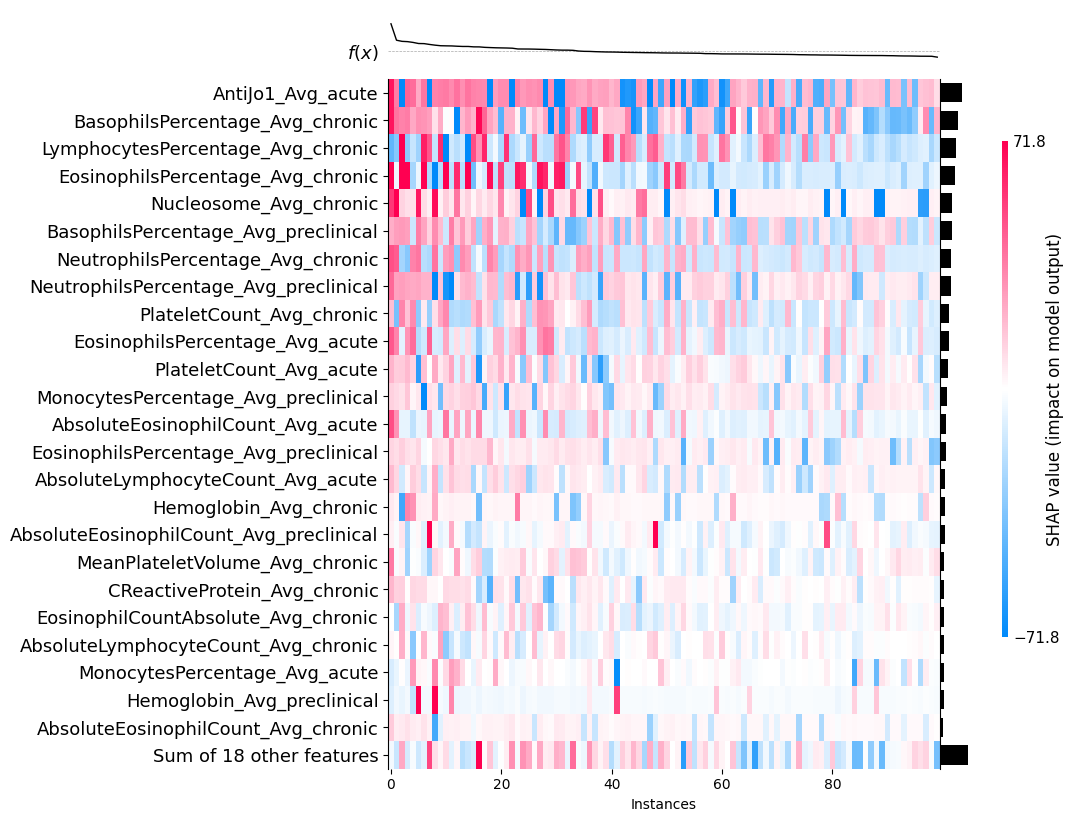

In [44]:
ax = shap.plots.heatmap(shap_values, max_display=25, 
                        instance_order=shap_values.sum(1),
                        show = False)
# 获取 Figure 对象
ax.set_aspect(5) 
fig = ax.get_figure()


In [14]:
X.columns

Index(['MonocytesPercentage_Avg_acute', 'AbsoluteLymphocyteCount_Avg_chronic',
       'EosinophilCountAbsolute_Avg_preclinical',
       'MeanCorpuscularVolume_Avg_acute', 'SMRNP_Avg_acute',
       'LymphocytesPercentage_Avg_preclinical', 'AntiJo1_Avg_acute',
       'EosinophilsPercentage_Avg_acute',
       'WhiteBloodCellCount_Avg_preclinical',
       'NeutrophilsPercentage_Avg_acute', 'PlateletCount_Avg_preclinical',
       'AntiSSA_Avg_acute', 'MeanCorpuscularHemoglobin_Avg_preclinical',
       'PlateletDistributionWidth_Avg_preclinical',
       'MeanCorpuscularVolume_Avg_chronic',
       'PlateletDistributionWidth_Avg_acute', 'RibosomalPProtein_Avg_acute',
       'Nucleosome_Avg_acute', 'NeutrophilsPercentage_Avg_chronic',
       'MeanCorpuscularVolume_Avg_preclinical', 'ImmunoglobulinE_Avg_acute',
       'Nucleosome_Avg_chronic', 'FreeThyroxine_Avg_acute',
       'WhiteBloodCellCount_Avg_acute', 'BasophilsPercentage_Avg_acute',
       'EosinophilsPercentage_Avg_preclinical',
      

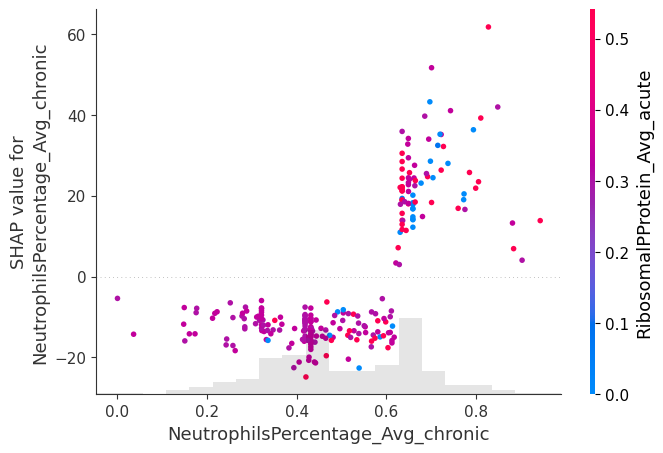

In [22]:
shap.plots.scatter(shap_values[:, "NeutrophilsPercentage_Avg_chronic"], color=shap_values[:, "RibosomalPProtein_Avg_acute"])
